In [10]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from rliable import metrics
from rliable import library as rly

from crl.utils.graphing import despine

# Function Definitions

In [11]:
def load_data(fp: str, param: str = 'length'):
    with open(fp, "rb") as f:
        six_bins_data = pickle.load(f)

    df_data = []
    # the data contains runs for a seed - each seed has 20 experiments with different
    # lengths - and at each length there are 250 evaluations - so need to unnest and
    # extract the relevant info.
    for exp in six_bins_data:
        seed = exp['seed']
        results = exp['results']
        for run in results:
            length = run[param]
            for i in range(250):
                returns_conf = run['returns_conf'][i]
                try:
                    returns_noconf = run['returns_noconf'][i]
                except KeyError:
                    returns_noconf = None
                run_info = {
                    'seed': seed,
                    'run': i,
                    param: length,
                    'returns_conf': returns_conf,
                    'returns_noconf': returns_noconf,
                }
                df_data.append(run_info)
    
    return pd.DataFrame(df_data)

def filter_bad_runs(df: pd.DataFrame, param: str, nominal_value: float, threshold: int) -> tuple[pd.DataFrame, list[int]]:
    'Filters the dataframe, removing runs which failed to achieve sufficient reward on the training envinronment'
    df_grp = df.groupby(['seed', param]).mean().reset_index()
    default_runs = df_grp[df_grp[param] == nominal_value]
    bad_seeds = default_runs.loc[default_runs['returns_noconf'] < threshold, 'seed'].to_list()

    df_filtered = df_grp[~df_grp['seed'].isin(bad_seeds)].drop(columns='run')
    print(f'Keeping {df_filtered['seed'].nunique()}/{df['seed'].nunique()} seeds')
    return df_filtered, bad_seeds

# CartPole

In [12]:
results_dir = "../../results"
six_bins_fp = f"{results_dir}/cartpole/run_six_bins/robustness_experiment.pkl"
eight_bins_fp = f"{results_dir}/cartpole/run_eight_bins/robustness_experiment.pkl"

# Combine the 6-binned and 8-binned data
df_raw = load_data(six_bins_fp)
df_raw = df_raw.rename(columns={'returns_conf': 'returns_conf_6'})

df_eight = load_data(eight_bins_fp)
df_raw['returns_conf_8'] = df_eight['returns_conf']
cp_filtered, bad_seeds = filter_bad_runs(df_raw, param='length', nominal_value=0.5, threshold=490)

Keeping 12/25 seeds


## Simple Median Plot

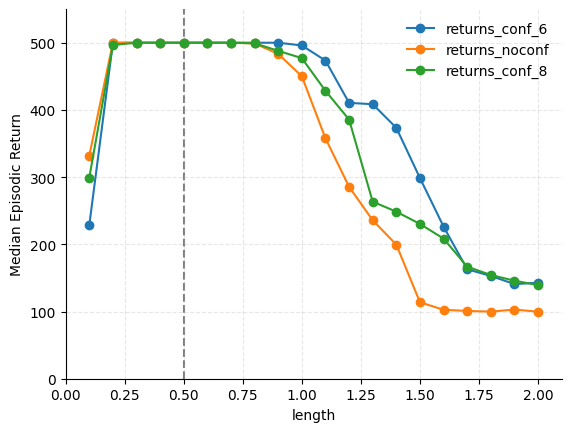

In [ ]:
# median plot looks pretty tasty
medians = cp_filtered.groupby('length')[['returns_conf_6', 'returns_noconf', 'returns_conf_8']].median()
ax = medians.plot(marker='o')
ax.set_ylabel('Median Episodic Return')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 550)
ax.set_xlim(0.0, 2.1)
ax.grid(alpha=0.3, linestyle='--')
ax.axvline(0.5, linestyle='--', color='k', zorder=0, alpha=0.5)
ax.legend(frameon=False);

## IQM + 95% CI using Rliable

In [ ]:
returns_conf_clean = cp_filtered.pivot(index='seed', columns='length', values='returns_conf_8').to_numpy()
returns_conf_clean = returns_conf_clean.reshape(-1, 1, 20)
returns_noconf_clean = cp_filtered.pivot(index='seed', columns='length', values='returns_noconf').to_numpy()
returns_noconf_clean = returns_noconf_clean.reshape(-1, 1, 20)

In [ ]:
print(cp_filtered.head())

    seed  length  returns_conf_6  returns_noconf  returns_conf_8
20     1     0.1         383.808         458.004         397.572
21     1     0.2         499.840         499.372         499.076
22     1     0.3         500.000         500.000         500.000
23     1     0.4         500.000         500.000         500.000
24     1     0.5         500.000         500.000         500.000


In [ ]:
score_dict = {
    'No Calibration': returns_noconf_clean,
    'Train-time Calibration': returns_conf_clean,
}

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., length])
                               for length in range(scores.shape[-1])])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  score_dict, iqm, reps=50_000)

Text(0.5, 0.98, 'Performance of fixed agent on Cartpole under distribution shift')

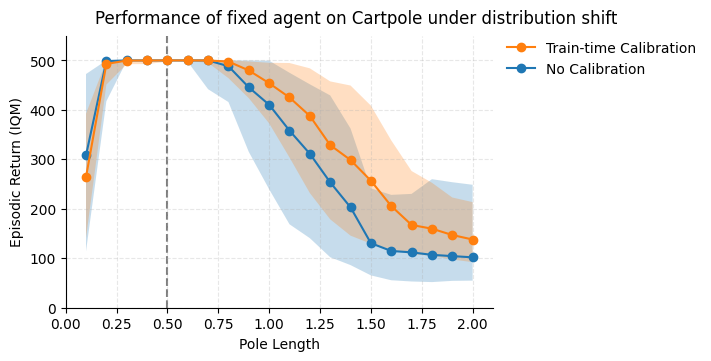

In [ ]:
xs = np.linspace(0.1, 2.0, 20)
fig, ax = plt.subplots(figsize=(7, 3.5), layout="constrained")  # or constrained_layout=True

for algo in aggregate_scores:
    iqms = aggregate_scores[algo]
    lower, upper = aggregate_score_cis[algo]
    ax.plot(xs, iqms, marker="o", label=algo)
    ax.fill_between(xs, lower, upper, alpha=0.25)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, 550)
ax.set_xlim(0.0, 2.1)
ax.grid(alpha=0.3, linestyle="--")
ax.axvline(0.5, linestyle="--", color="k", zorder=0, alpha=0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, reverse=True);
ax.set_ylabel("Episodic Return (IQM)")
ax.set_xlabel("Pole Length")
fig.suptitle('Performance of fixed agent on Cartpole under distribution shift')

## Ratio Plot

In [ ]:
cp_filtered['ratio'] = cp_filtered['returns_conf_6'] / cp_filtered['returns_noconf']
ratio_clean = cp_filtered.pivot(index='seed', columns='length', values='ratio').to_numpy().reshape(-1, 1, 20)
ratio_dict = {'Ratio': ratio_clean}

ratio_score, ratio_cis = rly.get_interval_estimates(
  ratio_dict, iqm, reps=50_000)

KeyboardInterrupt: 

Mean Improvement: 1.206x (1.022x - 1.579x)


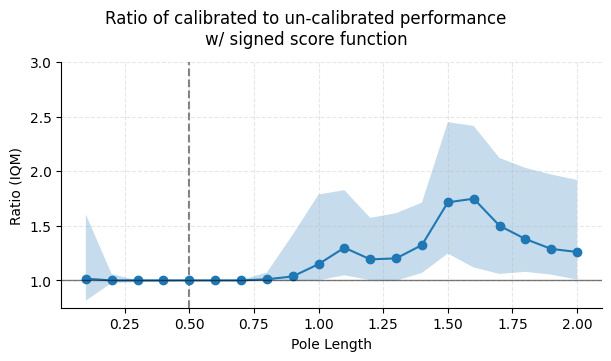

In [ ]:
def plot_improvement_curve(xs, ratio_score, ratio_cis, title: str, xlabel: str, nominal_value: float = 0.5, legend_title: str | None = None):
    fig, ax = plt.subplots(figsize=(6, 3.5), layout="constrained")  # or constrained_layout=True
    for algo in ratio_score:
        iqms = ratio_score[algo]
        lower, upper = ratio_cis[algo]
        ax.plot(xs, iqms, marker="o", label=algo)
        ax.fill_between(xs, lower, upper, alpha=0.25)

    ax.axhline(1.0, c='k', alpha=0.5, linewidth=1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(alpha=0.3, linestyle="--")
    ax.axvline(nominal_value, linestyle="--", color="k", zorder=0, alpha=0.5)
    ax.set_ylabel("Ratio (IQM)")
    ax.set_xlabel(xlabel)
    ax.set_ylim(0.75, 3.00)
    fig.suptitle(title)
    if legend_title is not None:
        ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1), title=legend_title)

    print(f'Mean Improvement: {iqms.mean():.3f}x ({lower.mean():.3f}x - {upper.mean():.3f}x)')
    plt.show()

lengths = np.linspace(0.1, 2.0, 20)
plot_improvement_curve(lengths, ratio_score, ratio_cis, title='Ratio of calibrated to un-calibrated performance\nw/ signed score function', xlabel='Pole Length')

## Probability of Improvement

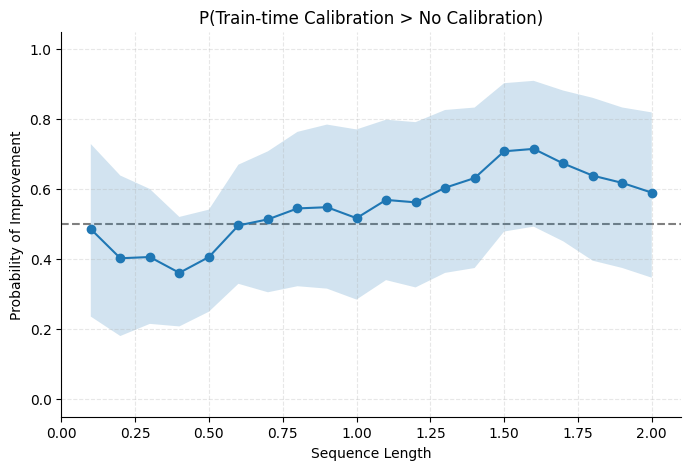

In [ ]:
import numpy as np
from rliable import library as rly
from rliable import metrics

# Assumes 'returns_conf_clean' and 'returns_noconf_clean' are defined
# and have the shape (num_runs, num_evaluation_points)

# 1. Create a dictionary with the pair of scores to compare.
# The order is (Y, X) for computing P(Y > X).
algorithm_pairs = {
    'Train-time > No Cal.': (returns_conf_clean, returns_noconf_clean)
}

# 2. Define a lambda function to compute the metric across the last dimension (lengths).
# This is analogous to your IQM-over-time calculation.
prob_improvement_fn = lambda x, y: np.array([
    metrics.probability_of_improvement(x[..., i], y[..., i])
    for i in range(x.shape[-1])])

# 3. Get interval estimates using stratified bootstrapping.
# The `rliable` authors use fewer reps (2000) for this metric.
probabilities, prob_cis = rly.get_interval_estimates(
    algorithm_pairs, prob_improvement_fn, reps=2000)

# 4. Plot the results.
comparison_name = 'Train-time > No Cal.'
probs = probabilities[comparison_name]
lower_ci, upper_ci = prob_cis[comparison_name]

fig, ax = plt.subplots(figsize=(8, 5))
xs = np.linspace(0.1, 2.0, 20) # Using the same lengths as your IQM plot

ax.plot(xs, probs, marker="o")
ax.fill_between(xs, lower_ci, upper_ci, alpha=0.2)

# Add a reference line at 0.5 for clarity
ax.axhline(0.5, ls='--', color='k', alpha=0.5, zorder=0)

ax.set_xlabel("Sequence Length")
ax.set_ylabel("Probability of Improvement")
ax.set_title("P(Train-time Calibration > No Calibration)")
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(0.0, 2.1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(alpha=0.3, linestyle="--")
plt.show()

# Signed vs. Unsigned Score

In [ ]:
unsigned_score_fp = f"{results_dir}/cartpole/run_unsigned_score/robustness_experiment.pkl"
unsigned_raw = load_data(unsigned_score_fp)
unsigned_grp = unsigned_raw.groupby(['seed', 'length']).mean().reset_index()
unsigned_filtered = unsigned_grp[~unsigned_grp['seed'].isin(bad_seeds)].drop(columns='run')

In [ ]:
# get ratio
unsigned_filtered['ratio'] = unsigned_filtered['returns_conf'] / unsigned_filtered['returns_noconf']
us_ratio_clean = unsigned_filtered.pivot(index='seed', columns='length', values='ratio').to_numpy().reshape(-1, 1, 20)
us_ratio_dict = {r'$\hat{y} - y$': ratio_clean, r'$|\hat{y} - y|$': us_ratio_clean}

us_ratio_score, us_ratio_cis = rly.get_interval_estimates(
  us_ratio_dict, iqm, reps=50_000)

Mean Improvement: 1.110x (1.000x - 1.514x)


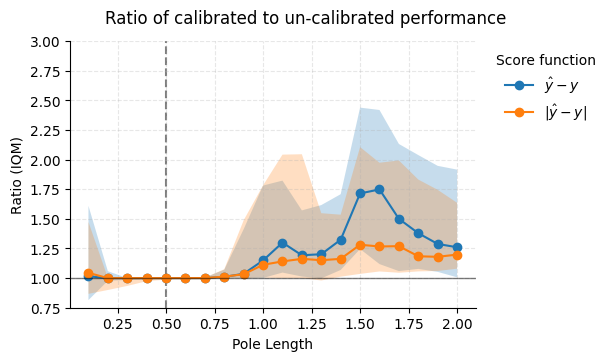

In [ ]:
plot_improvement_curve(xs, us_ratio_score, us_ratio_cis, xlabel='Pole Length', title='Ratio of calibrated to un-calibrated performance', legend_title="Score function")

# Test-Time Calibration

In [ ]:
tt_fp = f"{results_dir}/cartpole/run_testtime_adaptation/testtime_adaptation.pkl"
tt_raw = load_data(tt_fp)
tt_grp = tt_raw.groupby(['seed', 'length']).mean().reset_index()
tt_filtered = tt_grp[~tt_grp['seed'].isin(bad_seeds)].drop(columns='run')
tt_filtered['returns_noconf'] = cp_filtered['returns_noconf']

In [ ]:
# get ratio
tt_filtered['ratio'] = tt_filtered['returns_conf'] / tt_filtered['returns_noconf']
tt_ratio_clean = tt_filtered.pivot(index='seed', columns='length', values='ratio').to_numpy().reshape(-1, 1, 20)
tt_ratio_dict = {'No test-time tuning': ratio_clean, 'Test-time tuning': tt_ratio_clean}

tt_ratio_score, tt_ratio_cis = rly.get_interval_estimates(
  tt_ratio_dict, iqm, reps=50_000)

Mean Improvement: 1.102x (0.880x - 1.502x)


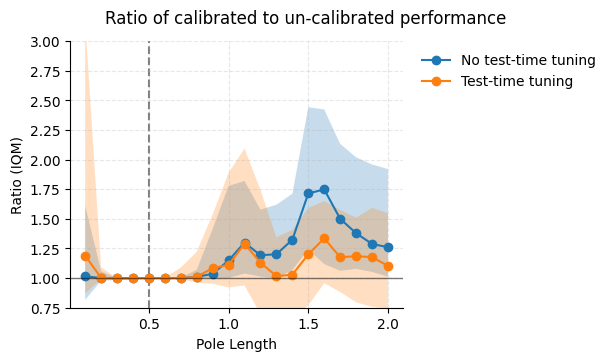

In [ ]:
title = 'Ratio of calibrated to un-calibrated performance'
xlabel = 'Pole Length'

plot_improvement_curve(xs, tt_ratio_score, tt_ratio_cis, title, xlabel, legend_title='')

# MountainCar

In [ ]:
mc_threshold = -120
param = 'gravity'
nominal_value = 0.0025
gravity_vals = np.arange(0.001, 0.005 + 0.00025, 0.00025)

mountaincar_6 = f"{results_dir}/mountaincar/gravity_6bins/robustness_experiment.pkl"
mountaincar_8 = f"{results_dir}/mountaincar/gravity_8bins/robustness_experiment.pkl"

mc_raw_6 = load_data(mountaincar_6, param='gravity')
mc_raw_8 = load_data(mountaincar_8, param='gravity')

mc_filtered, _ = filter_bad_runs(mc_raw_8, param, nominal_value=nominal_value, threshold=mc_threshold)

# get ratio. Note that for mountaincar the returns are negative, so
# need to offset the rewards to reflect that fact
min_reward = -210
mc_filtered['ratio'] = (mc_filtered['returns_conf'] - min_reward) / (mc_filtered['returns_noconf'] - min_reward)
mc_ratio_clean = mc_filtered.pivot(index='seed', columns=param, values='ratio').to_numpy().reshape(-1, 1, len(gravity_vals))
mc_ratio_dict = {'mountaincar_6': mc_ratio_clean}

mc_ratio_score, mc_ratio_cis = rly.get_interval_estimates(
  mc_ratio_dict, iqm, reps=50_000)

Keeping 17/25 seeds


Mean Improvement: 1.200x (1.025x - 1.670x)


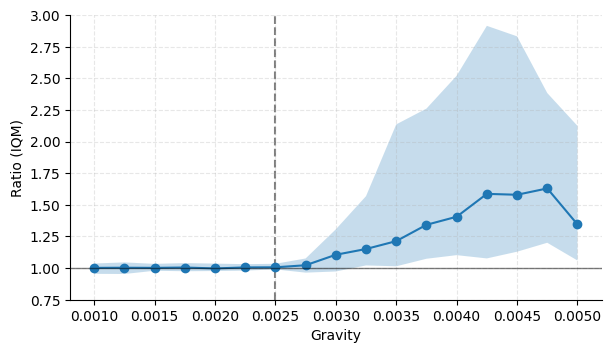

In [ ]:
plot_improvement_curve(gravity_vals, mc_ratio_score, mc_ratio_cis, nominal_value=nominal_value, xlabel='Gravity', title='')

# Acrobot

In [ ]:
mc_threshold = -100
param = 'LINK_LENGTH_1'
nominal_value = 1.0
link_vals = np.linspace(0.5, 2.0, 16)
acrobot_6 = f"{results_dir}/acrobot/linklength1_6bins_100k/robustness_experiment.pkl"
acrobot_8 = f"{results_dir}/acrobot/linklength1_8bins_100k/robustness_experiment.pkl"

ab_raw_6 = load_data(acrobot_6, param=param)
ab_raw_8 = load_data(acrobot_8, param=param)

ab_filtered, _ = filter_bad_runs(ab_raw_8, param, nominal_value=nominal_value, threshold=mc_threshold)

# get ratio. Note that for mountaincar the returns are negative, so
# need to offset the rewards to reflect that fact
min_reward = -500
ab_filtered['ratio'] = (ab_filtered['returns_conf'] - min_reward) / (ab_filtered['returns_noconf'] - min_reward)
ab_ratio_clean = ab_filtered.pivot(index='seed', columns=param, values='ratio').to_numpy().reshape(-1, 1, len(link_vals))
ab_ratio_dict = {'mountaincar_6': ab_ratio_clean}

ab_ratio_score, ab_ratio_cis = rly.get_interval_estimates(
  ab_ratio_dict, iqm, reps=50_000)

Keeping 22/25 seeds


Mean Improvement: 0.999x (0.995x - 1.002x)


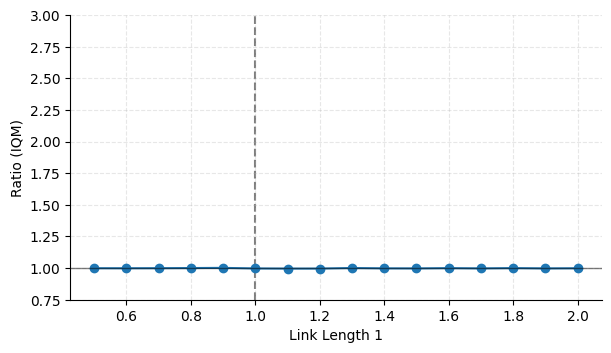

In [ ]:
plot_improvement_curve(link_vals, ab_ratio_score, ab_ratio_cis, nominal_value=nominal_value, xlabel='Link Length 1', title='')

# CQL Comparison

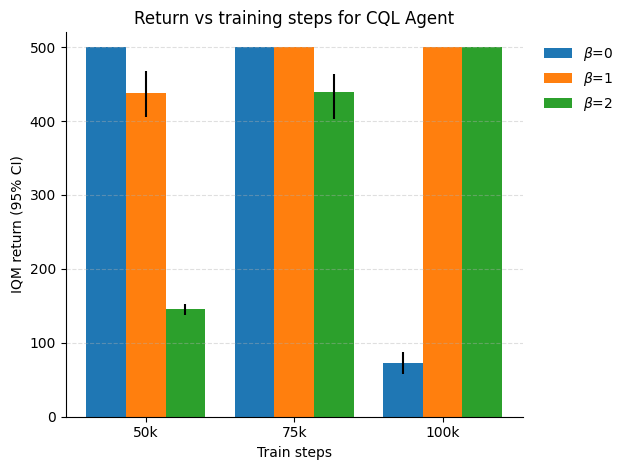

In [ ]:
cql_data = pd.read_pickle(f'{results_dir}/cartpole/cql/cql_results_withreturns.pkl')
cql_df = pd.DataFrame(cql_data)
cql_df = cql_df.explode('returns')

alphas = [0.0, 1.0, 2.0]
steps_order = [50_000, 75_000, 100_000]  # x-axis order

# Build score_dict: one entry per (alpha, train_steps). Each is [num_seeds, 1]
score_dict = {}
for alpha in alphas:
    for step in steps_order:
        sub = cql_df[(cql_df['alpha'] == alpha) & (cql_df['train_steps'] == step)]
        # 1 value per seed
        scores = sub['returns'].to_numpy().reshape(-1, 1)
        label = f"α={alpha}|{step//1000}k"
        score_dict[label] = scores

# IQM per “task” (we have a single placeholder task of size 1)
def iqm_fn(scores):
    # scores: [num_seeds, num_tasks]
    return np.array([metrics.aggregate_iqm(scores[:, t]) for t in range(scores.shape[1])])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(score_dict, iqm_fn, reps=50_000)

# Plot grouped bars with asymmetric error bars from the bootstrap CIs
x = np.arange(len(steps_order))
bar_width = 0.8 / len(alphas)

for i, alpha in enumerate(alphas):
    means, lower_err, upper_err = [], [], []
    for step in steps_order:
        key = f"α={alpha}|{step//1000}k"
        mean = float(aggregate_scores[key][0])          # scalar IQM
        ci_lo, ci_hi = aggregate_score_cis[key][:, 0]   # lower/upper for that scalar
        means.append(mean)
        lower_err.append(mean - ci_lo)
        upper_err.append(ci_hi - mean)

    offsets = x + (i - (len(alphas)-1)/2) * bar_width
    yerr = np.vstack([lower_err, upper_err])           # asymmetric errors
    plt.bar(offsets, means, width=bar_width, yerr=yerr, capsize=0, label=r'$\beta$' + f'={alpha:.0f}')

plt.xticks(x, [f"{s//1000}k" for s in steps_order])
despine(plt.gca())
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(None, 520)
plt.xlabel('Train steps')
plt.ylabel('IQM return (95% CI)')
plt.legend(bbox_to_anchor=(1.02, 1), frameon=False)
plt.title('Return vs training steps for CQL Agent')
plt.tight_layout()

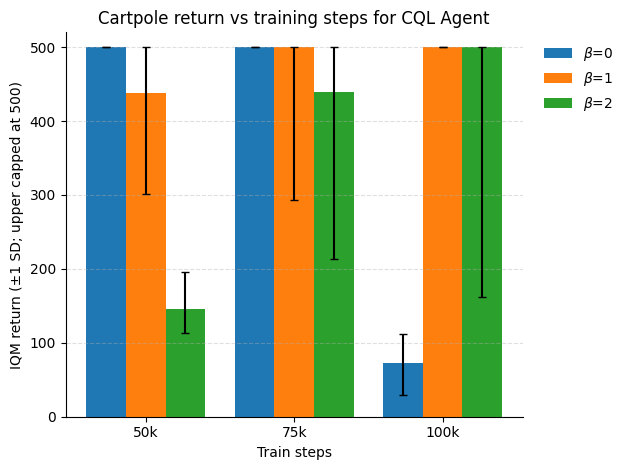

In [ ]:
# Build score_dict: one entry per (alpha, train_steps). Each is [num_seeds, 1]
score_dict = {}
for alpha in alphas:
    for step in steps_order:
        sub = cql_df[(cql_df['alpha'] == alpha) & (cql_df['train_steps'] == step)]
        # 1 value per seed
        scores = sub['returns'].to_numpy().reshape(-1, 1)
        label = f"α={alpha}|{step//1000}k"
        score_dict[label] = scores

# --- Replace rliable CIs with SD-based asymmetric errors (upper capped at 500) ---
MAX_SCORE = 500.0

x = np.arange(len(steps_order))
bar_width = 0.8 / len(alphas)

for i, alpha in enumerate(alphas):
    means, lower_err, upper_err = [], [], []
    for step in steps_order:
        key = f"α={alpha}|{step//1000}k"
        vals = score_dict[key].ravel()

        # # capped STD
        # mean = np.mean(vals)
        # sd = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
        # up_cap = max(0.0, MAX_SCORE - mean)
        # up = min(sd, up_cap)
        # low = sd
        # means.append(mean)
        # lower_err.append(low)
        # upper_err.append(up)

        # Error bars: 10th and 90th quantiles
        center = float(metrics.aggregate_iqm(vals))
        q10, q90 = np.quantile(vals, [0.10, 0.90])
        means.append(center)
        lower_err.append(max(0.0, center - q10))
        upper_err.append(max(0.0, q90 - center))

    offsets = x + (i - (len(alphas)-1)/2) * bar_width
    yerr = np.vstack([lower_err, upper_err])  # asymmetric errors
    plt.bar(offsets, means, width=bar_width, yerr=yerr, capsize=3, label=r'$\beta$' + f'={alpha:.0f}')

plt.xticks(x, [f"{s//1000}k" for s in steps_order])
despine(plt.gca())
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(None, 520)
plt.xlabel('Train steps')
plt.ylabel('IQM return (±1 SD; upper capped at 500)')
plt.legend(bbox_to_anchor=(1.02, 1), frameon=False)
plt.title('Cartpole return vs training steps for CQL Agent')
plt.tight_layout()

In [ ]:
np.quantile(vals, 0.1)

np.float64(161.9)

In [ ]:
center

72.1

In [ ]:
mean

np.float64(444.61)